## Apply Traditional Trading Techniques to Defi

**Gautham Nagendra**

**Background:** 

All novice traders have seen the effect of high-frequency trading where the trade execution happens in a fraction of seconds. Hedge funds today are able to de-ploy their trading strategies into algorithmic bots which makes decision-based on the AI models. I plan to take these similar strategies and apply them to the world of decentralized finance. As a goal, I want to make this model/output of this project accessible to all.

> In a decentralized market, technology enables investors to deal directly with each other instead of operating from within a centralized exchange. Virtual markets that use decentralized currency, or cryptocurrencies, are examples of decentralized markets.

https://www.investopedia.com/terms/d/decentralizedmarket.asp


1. Overview
2. Technical Indicators
    * Bollinger Bands 
    * RSI
    * Daily Returns
3. Technical Indicators with a Twist
4. Bot - Test it out
5. NLP
6. Next Steps



## 1. Overview

The initial objective of this project is to understand how Technical indicators and Sentiment analysis could help in making better buy/sell decisions in the traditional market. The strategy discussed is from a Statistical perspective and not from Financial thinking. The idea here is to use the existing stock data to make better decisions and test/develop this trading strategy via Lumibot. 

Use Technical Indicators to predict stock price action and demonstrate how a particular stock can beat S&P 500. The end objective of the project is to explore advanced predictions using ML and minimize the risk of return in your portfolio. This approach would comprehensive to include crypto assets as well. 

The value of this project would be to identify patterns by narrowing down on the critical features that affect the price movement of equity. We would need to consider seasonality and special factors that might influence price action and capture these special causes as model behavior that can be substituted for special events.


In [1]:
# Import the required python packages

import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import mplfinance as mpf
from datetime import datetime, timedelta


In [2]:
#Import data from yahoo Finance

# I am limiting the start date - considering from the begining of 2020 upto current/previous trading day
start = datetime(2020, 1, 1)
end = datetime.now()

#For easy of understanding I have considered SPDR S&P 500 ETF Fund - Ticker "SPY"
sp500= yf.download("SPY", start=start, end=end)

#check the dataframe

sp500.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,323.540009,324.890015,322.529999,324.869995,314.719177,59151200
2020-01-03,321.160004,323.640015,321.100006,322.410004,312.336121,77709700
2020-01-06,320.489990,323.730011,320.359985,323.640015,313.527618,55653900
2020-01-07,323.019989,323.540009,322.239990,322.730011,312.646057,40496400
2020-01-08,322.940002,325.779999,322.670013,324.450012,314.312378,68296000


## 2. Technical Indicators

Technical indicator is a mathematical calculation based on historic price, volume, or (in the case of futures contracts) open interest information that aims to forecast financial market direction. Technical indicators are a fundamental part of technical analysis and are typically plotted as a chart pattern to try to predict the market trend.Indicators generally overlay on price chart data to indicate where the price is going, or whether the price is in an "overbought" condition or an "oversold" condition.

### 2.1 Bollinger Bands

The indicator is made up of 3 lines  – a middle band and two outer ones. The middle band is moving average, usually with the period of 20. Usually the outer bands are set 2 standard deviations above and below the middle band.

In [3]:
#define the period for which we want to calcualte the bands for
period = 20

#Calclate the Mean or the simple moving average for that period
sp500['SMA']= sp500['Close'].rolling(window=period).mean()

#calcualte the standard deviatation for that period
sp500["STD"]= sp500['Close'].rolling(window=period).std()

#Establish the Upper and lower Bollinger bands by adding/substracting 2*Sd
#Add Upper and lower column to the dataframe
sp500["Upper2"]= sp500['SMA']+(sp500['STD']*2)
sp500["Lower2"]= sp500['SMA']-(sp500['STD']*2)

#Look at the data tail
sp500.tail()

,Open,High,Low,Close,Adj Close,Volume,SMA,STD,Upper2,Lower2
Date,,,,,,,,,,
2021-12-30,477.929993,479.000000,475.670013,476.160004,476.160004,55329000,466.772502,7.300824,481.374151,452.170854
2021-12-31,475.640015,476.859985,474.670013,474.959991,474.959991,65210500,467.650502,7.169057,481.988615,453.312389
2022-01-03,476.299988,477.850006,473.850006,477.709991,477.709991,72668200,468.865001,6.671615,482.208231,455.521771
2022-01-04,479.220001,479.980011,475.579987,477.549988,477.549988,71178700,469.803000,6.497065,482.797129,456.808871
2022-01-05,477.160004,477.980011,468.280090,468.380005,468.380005,90303992,469.808000,6.495869,482.799738,456.816262


### 2.1.1 Lets Graph the bollinger band stats

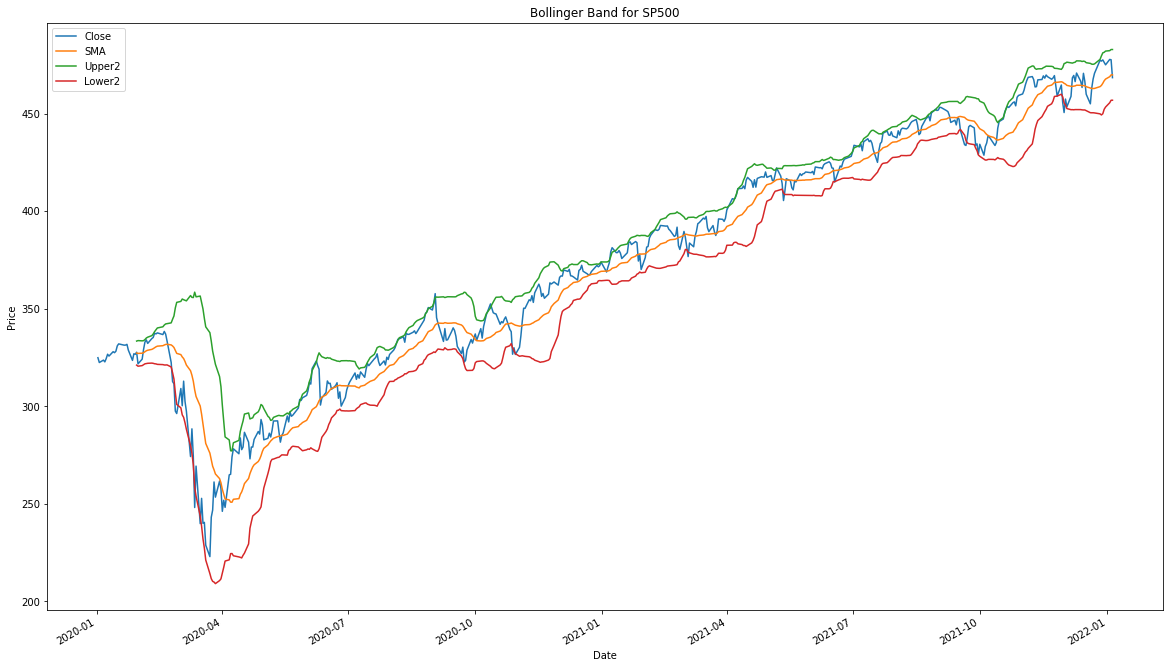

In [4]:
# Create a list with all the variables to plot
column_list=['Close','SMA','Upper2','Lower2']

#Use Plot fucntion and display the graph
sp500[column_list].plot(figsize=(20,12))

plt.title('Bollinger Band for SP500')
plt.ylabel('Price') 

plt.show()

Above Graph by itself does not provide much information, lets improve this

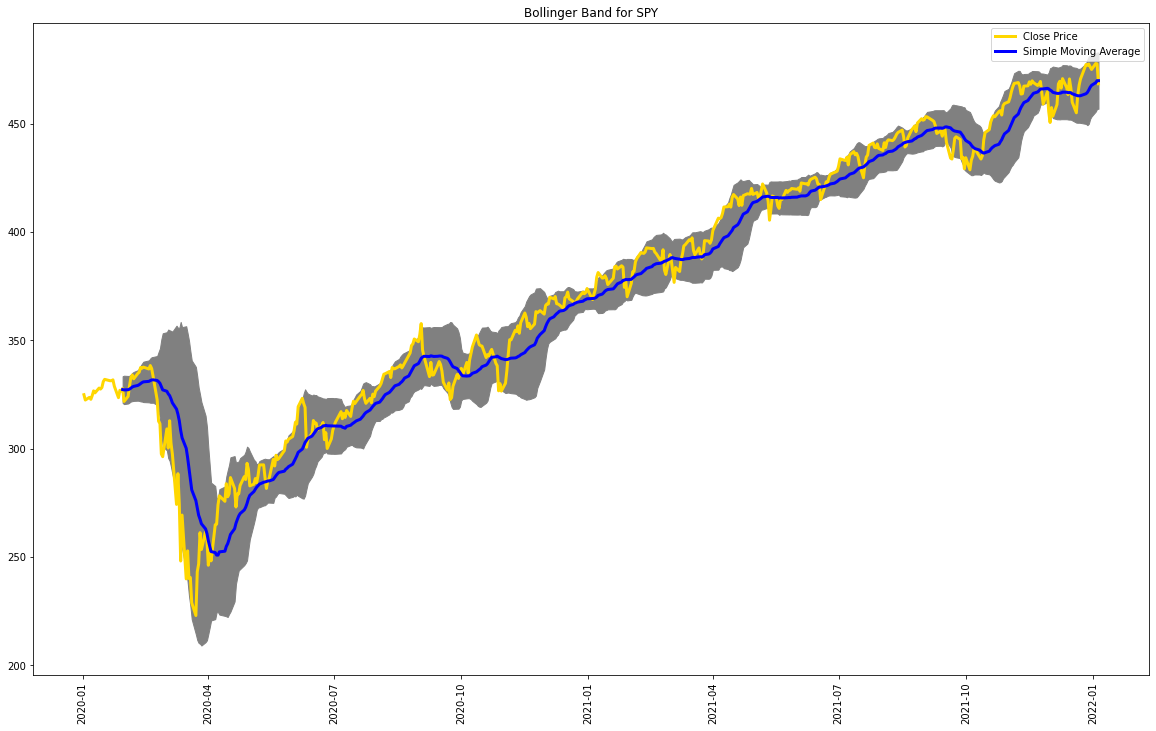

In [5]:
# Plot the data in similar scatter but make it much more readable

fig=plt.figure(figsize=(20,12))
ax=fig.add_subplot(1,1,1)

x_axis=sp500.index

ax.fill_between(x_axis,sp500['Upper2'],sp500['Lower2'],color='grey')

ax.plot(x_axis,sp500["Close"],color='gold',lw=3,label='Close Price')
ax.plot(x_axis,sp500["SMA"],color='blue',lw=3,label='Simple Moving Average')

ax.set_title("Bollinger Band for SPY")
plt.xticks(rotation=90)
ax.legend()

plt.show()

Lets Further improve this by adding Buy/Sell Decissions to this graph

Basic the price is less than 2 standard deviation from the moving average a buy is triggered and when the price action passes the more than 2 standard deviation above the moving average an sell is triggered

In [6]:
# Below function is add logic as when to sell based on the standard deviation action
def get_signal(data):
    buy_signal=[]# Create empty list for buy
    sell_signal=[]# Create empty lsit for sell
    for i in range(len(data['Close'])):

        if data['Close'][i] > data["Upper2"][i]: ## Then you should sell
            buy_signal.append(np.nan)
            sell_signal.append(data['Close'][i])

        
        elif data['Close'][i] < data['Lower2'][i]: ## Then You should Buy
            buy_signal.append(data['Close'][i])
            sell_signal.append(np.nan)
        
        else:
            buy_signal.append(np.nan)
            sell_signal.append(np.nan)
            
    return (buy_signal,sell_signal)

#Add Buy and sell Columns to the dataframe

sp500['Buy'] = get_signal(sp500)[0]
sp500['Sell']= get_signal(sp500)[1]

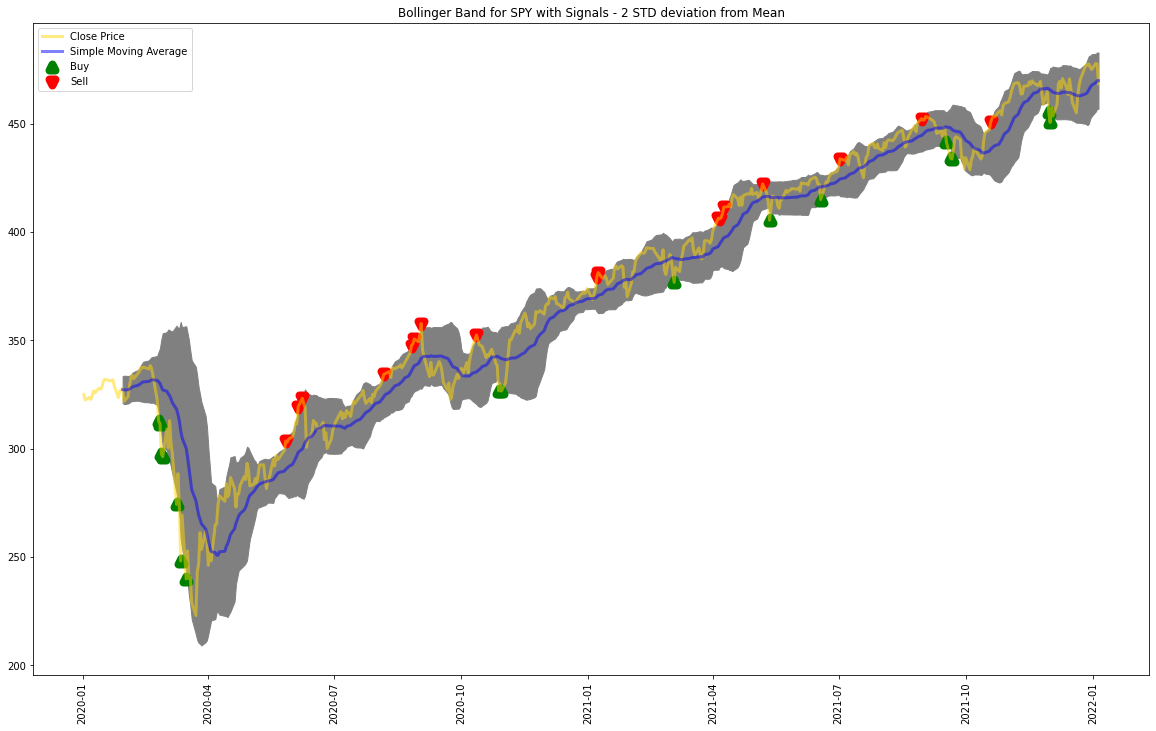

In [7]:
# Lets plot the buy and sell signal on the above graph

fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(1,1,1)
x_axis = sp500.index
ax.fill_between(x_axis,sp500['Upper2'],sp500['Lower2'],color='grey')

ax.plot(x_axis,sp500["Close"],color='gold',lw=3,label='Close Price',alpha=0.5)
ax.plot(x_axis,sp500["SMA"],color='blue',lw=3,label='Simple Moving Average',alpha=0.5)

ax.scatter(x_axis,sp500["Buy"],color ='green',lw=8,marker='^',alpha=1,label = "Buy")
ax.scatter(x_axis,sp500["Sell"],color ='red',lw=8,marker='v',alpha=1, label = 'Sell')

ax.set_title("Bollinger Band for SPY with Signals - 2 STD deviation from Mean")
plt.xticks(rotation = 90)
ax.legend()

plt.show()

## 2.2 Relative Strength Index (RSI)

RSI is as a momentum oscillator, measuring the velocity and magnitude of price movements. Momentum is the rate of the rise or fall in price. The RSI computes momentum as the ratio of higher closes to lower closes: stocks which have had more or stronger positive changes have a higher RSI than stocks which have had more or stronger negative changes.

The RSI is most typically used on a 14-day timeframe, measured on a scale from 0 to 100, with high and low levels marked at 70 and 30, respectively. Short or longer timeframes are used for alternately shorter or longer outlooks. High and low levels—80 and 20, or 90 and 10—occur less frequently but indicate stronger momentum.

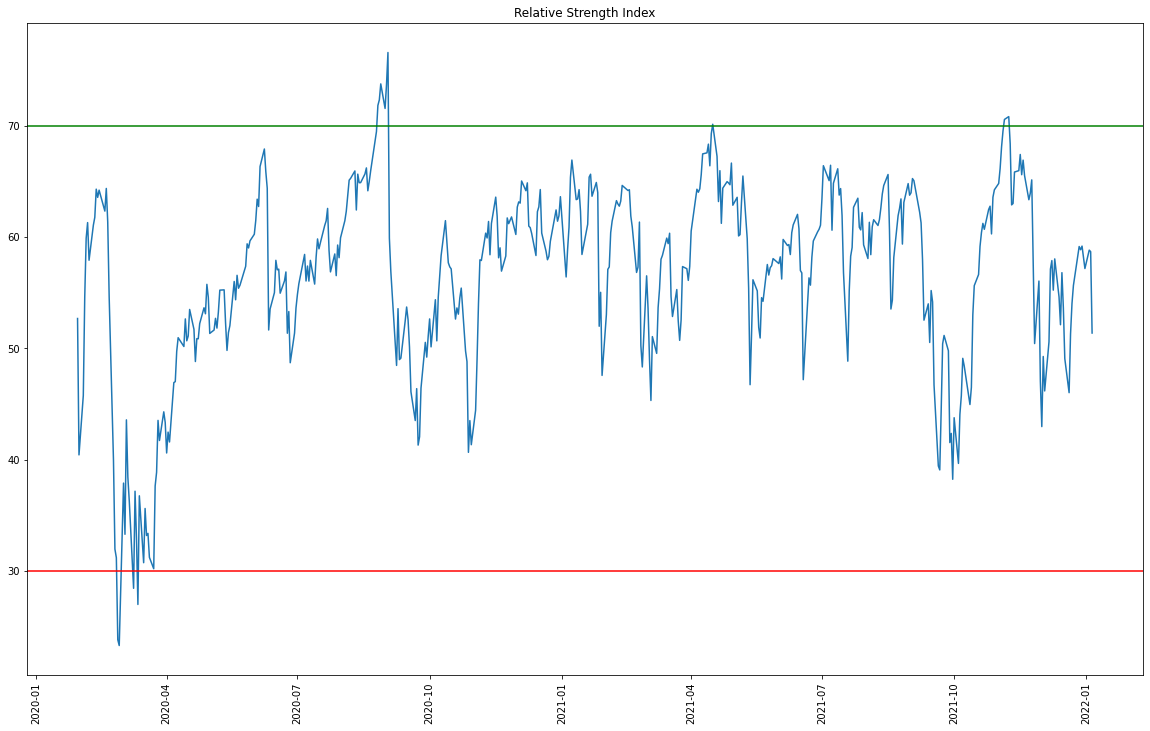

In [8]:
## Create Python Object for RSI
import ta
fig = plt.figure(figsize=(20,12))

sp500["rsi"] = ta.momentum.RSIIndicator(sp500['Close'],window=20).rsi()

plt.plot(sp500.index,sp500['rsi'])

plt.axhline(y = 30,color='r')
plt.axhline(y = 70,color='g')
plt.xticks(rotation=90)
plt.title("Relative Strength Index")


plt.show()

## 2.3 Daily Returns

The daily return measures the dollar change in a stock’s price as a percentage of the previous day’s closing price. A positive return means the stock has grown in value, while a negative return means it has lost value. A stock with lower positive and negative daily returns is typically less risky than a stock with higher daily returns, which create larger swings in value.

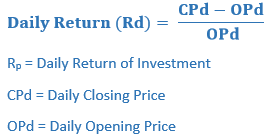

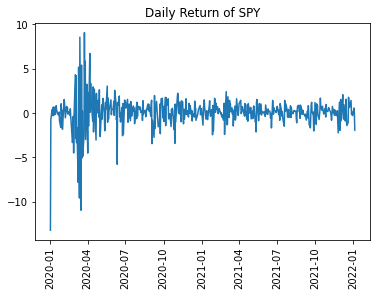

Text(0.5, 1.0, 'Histogram of Daily returns')

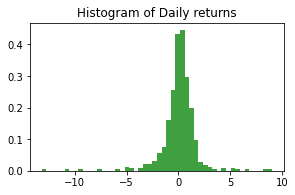

In [9]:
# import technical Analysis library
import ta

sp500["dlr"]=ta.others.DailyReturnIndicator(sp500['Close']).daily_return()

plt.plot(sp500.index,sp500['dlr'])

plt.xticks(rotation=90)
plt.title("Daily Return of SPY")
plt.show()
plt.rcParams["figure.figsize"] = (10,6)

plt.subplot(222)

plt.hist(sp500['dlr'],bins=50,density=True, facecolor='g', alpha=0.75)
plt.title("Histogram of Daily returns")

## 3. Technical Indicators with a Twist

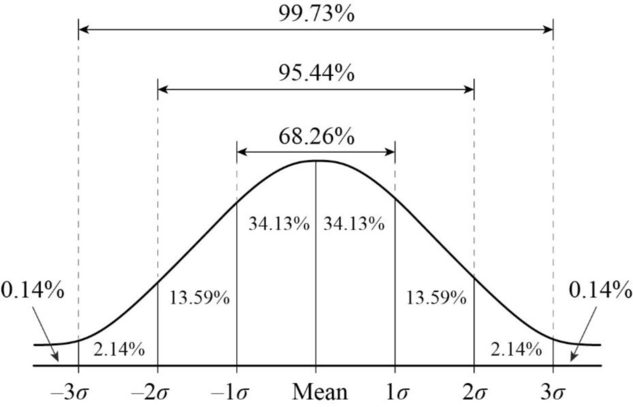

Parametric data can be modelled using some basic satistics rules of Normal Curve behaviour

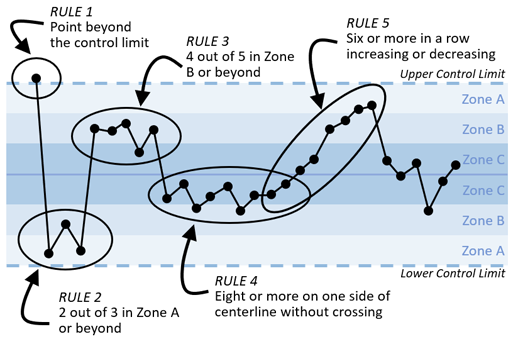

In [10]:
## Adding 3 std devations to our dataframe

sp500["Upper3"]= sp500['SMA']+(sp500['STD']*3)
sp500["Lower3"]= sp500['SMA']-(sp500['STD']*3)
sp500["Upper1"]= sp500['SMA']+(sp500['STD'])
sp500["Lower1"]= sp500['SMA']-(sp500['STD'])

sp500.tail()

,Open,High,Low,Close,Adj Close,Volume,SMA,STD,Upper2,Lower2,Buy,Sell,rsi,dlr,Upper3,Lower3,Upper1,Lower1
Date,,,,,,,,,,,,,,,,,,
2021-12-30,477.929993,479.000000,475.670013,476.160004,476.160004,55329000,466.772502,7.300824,481.374151,452.170854,NaN,NaN,58.141493,-0.276453,488.674975,444.870029,474.073326,459.471678
2021-12-31,475.640015,476.859985,474.670013,474.959991,474.959991,65210500,467.650502,7.169057,481.988615,453.312389,NaN,NaN,57.173534,-0.252019,489.157672,446.143332,474.819559,460.481445
2022-01-03,476.299988,477.850006,473.850006,477.709991,477.709991,72668200,468.865001,6.671615,482.208231,455.521771,NaN,NaN,58.827041,0.578996,488.879845,448.850157,475.536616,462.193386
2022-01-04,479.220001,479.980011,475.579987,477.549988,477.549988,71178700,469.803000,6.497065,482.797129,456.808871,NaN,NaN,58.688264,-0.033494,489.294194,450.311806,476.300064,463.305935
2022-01-05,477.160004,477.980011,468.280090,468.380005,468.380005,90303992,469.808000,6.495869,482.799738,456.816262,NaN,NaN,51.376511,-1.920214,489.295608,450.320393,476.303869,463.312131


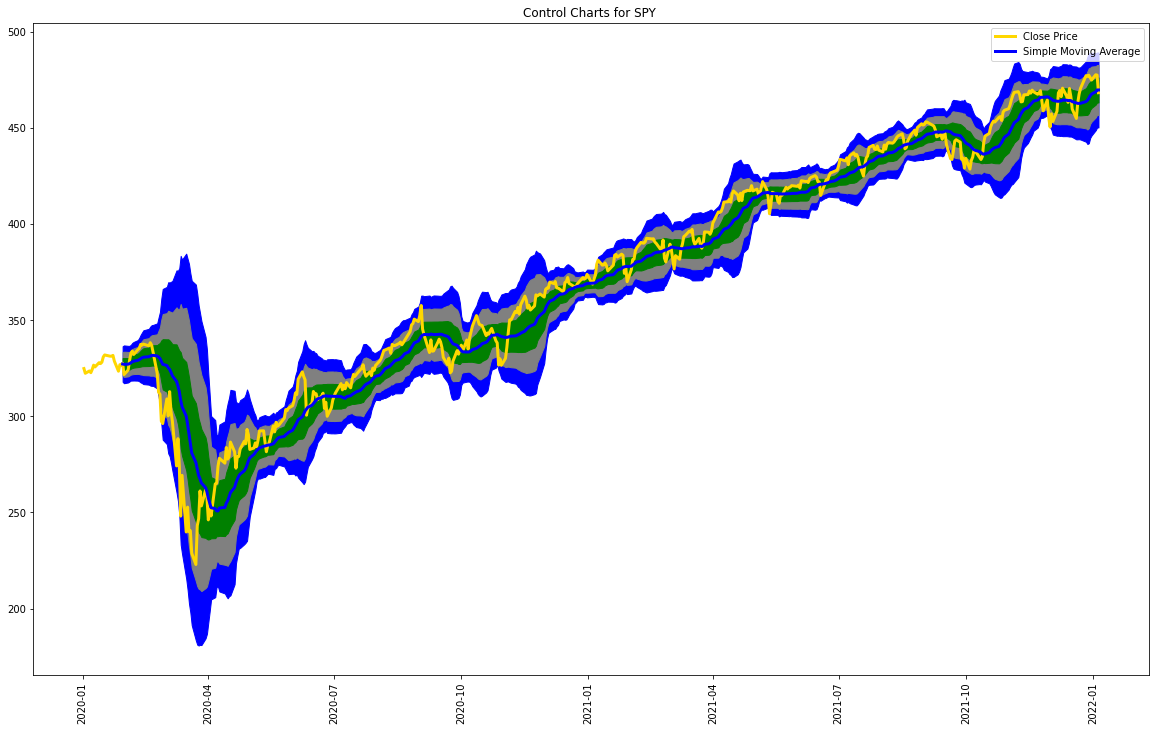

In [11]:
# Lets see how this looks  on the graph

fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(1,1,1)
x_axis = sp500.index

ax.fill_between(x_axis,sp500['Upper3'],sp500['Lower3'],color='blue')
ax.fill_between(x_axis,sp500['Upper2'],sp500['Lower2'],color='grey')
ax.fill_between(x_axis,sp500['Upper1'],sp500['Lower1'],color='green')

ax.plot(x_axis,sp500["Close"],color='gold',lw=3,label='Close Price')
ax.plot(x_axis,sp500["SMA"],color='blue',lw=3,label='Simple Moving Average')

ax.set_title("Control Charts for SPY ")
plt.xticks(rotation=90)
ax.legend()

plt.show()

### Stratergy using Signs of a squeeze:

1. Bollinger Bands narrow as volatility decreases.

To enter the trade:

    (A) Set buy entry just above upper band.

    (B) Set sell-short entry just below lower band.

Once in the trade:

    (C) Place initial stop above or below opposite band.

    (D) Use trailing stop to lock in gains as trade progresses. bollinger bands

2. Trading a breakout

Signs of a breakout:

    [A] The stock breaks higher out of its previous range, increasing volatility and pushing bands apart.

    [B] As volatility wanes, the lower band turns up, suggesting that momentum is slowing.

To take profits:

    (A) Take initial profit by selling part of position.

    (B) Manage remaining position with a trailing stop.

### Putting all technical Analysis together

In [12]:
import ta

sp500["rsi"] = ta.momentum.RSIIndicator(sp500['Close'],window = 14).rsi()
sp500["dlr"] = ta.others.DailyReturnIndicator(sp500['Close']).daily_return()

<Figure size 1584x1008 with 0 Axes>

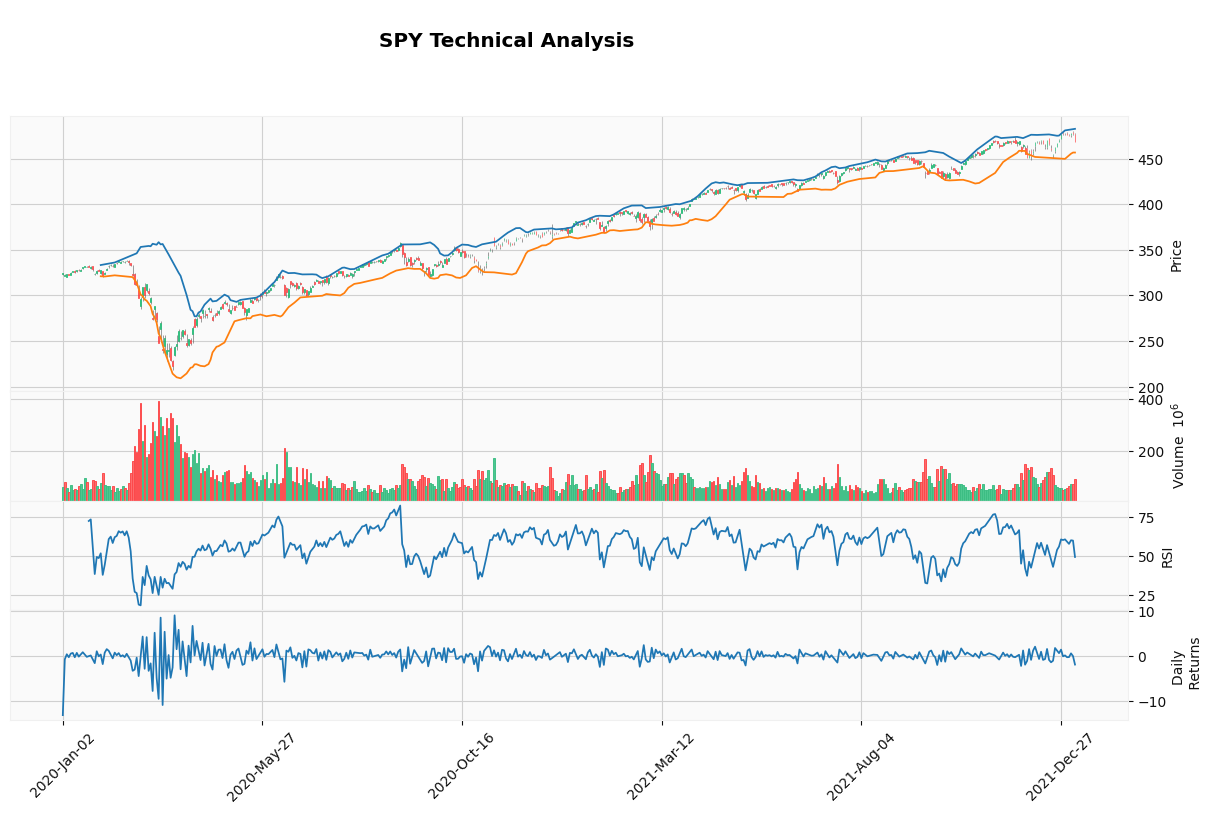

In [13]:
fig=plt.figure(figsize = (22,14))

rsi_plot = mpf.make_addplot(sp500['rsi'], panel=2,ylabel="RSI")

dlr_plot = mpf.make_addplot(sp500['dlr'], panel=3,ylabel="Daily \n Returns")
ap = mpf.make_addplot(sp500[['Upper2','Lower2']],ylabel='Bollinger Bands')


mpf.plot(sp500,type='candle',style='yahoo',volume=True,addplot=[rsi_plot,dlr_plot,ap],title="\nSPY Technical Analysis",figratio=(18,10),figscale=1.5)

## 4. Build the bot

Connect via Alpaca API and deploy the bot

Documentation refered
https://github.com/alpacahq/example-hftish 

## 5. Natural Langauge Processing

As the next steps, I want to factor in sentiment analysis that can support Technical indicators directions. I also plan to explore advanced techniques such as CNN or GANs in deep learning. For example, the ability of the model to look at the finanical news channel and based on the behaviors of the speaker predict the market sentiment - CEO of a company talking on Bloomberg can influence institutional traders

## 6. Next steps

For testing, model collect trading data from various exchanges

https://www.livecoinwatch.com/tools/api 

https://tokensniffer.com/ 

https://cryptocurrencyalerting.com/rest-api.html 


Improve your model to make better predictions and deploy this on an open-source

